# PMEmo Dataset: Baseline Models with Rich Statistical Features

---

## 📋 Task Overview

This notebook implements emotion regression model training for the PMEmo dataset using **Rich Statistical Features** to enhance performance.

### 🎯 Objectives
- Use PMEmo dataset (chorus segments)
- **Plan B: Rich Statistical Features** ✨
  - Beyond mean/std only
  - Add min, max, median, percentiles, skewness, kurtosis
  - Expected improvement: R² +0.05
- Compare Linear Regression and Random Forest
- Compare with DEAM results

### 📊 Data
- **Input**: PMEmo chorus segments (MP3)
- **Features**: Rich statistical features (9 statistics per audio descriptor)
- **Targets**: Valence (pleasure), Arousal (activation)
- **Size**: 794 songs

### 🤖 Models
1. **Linear Regression** (baseline)
2. **Random Forest** (advanced)
3. **SVR** (paper method)

### 📈 Evaluation Metrics
- **R²** - Coefficient of determination (higher is better)
- **RMSE** - Root mean squared error (lower is better)
- **NRMSE** - Normalized RMSE (lower is better)
- **MAE** - Mean absolute error (lower is better)
- **Pearson r** - Correlation coefficient

### ✨ Improvement Strategy
**Plan B: Rich Statistical Features**
- Original: mean, std (2 statistics)
- New: min, max, median, q25, q75, skewness, kurtosis (7 additional)
- **Total: 9 statistics per audio feature**

---


## 1. Import Libraries and Setup


In [1]:
# Data processing
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats

# Audio processing
import librosa
from tqdm import tqdm

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print("Random seed:", RANDOM_STATE)


Random seed: 42


## 2. Load Data


In [3]:
# Set paths
# Note: English notebooks are in notebooks_en/ subdirectory
BASE_DIR = Path('../..')  # Go up two levels: notebooks_en/ -> notebooks/ -> Semester1/
DATA_DIR = BASE_DIR / 'data' / 'PMEmo2019' / 'PMEmo2019'
AUDIO_DIR = DATA_DIR / 'chorus'
OUTPUT_DIR = BASE_DIR / 'models' / 'pmemo_baseline'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load metadata
metadata = pd.read_csv(DATA_DIR / 'metadata.csv')
print(f"Number of songs: {len(metadata)}")
print(f"Columns: {list(metadata.columns)}")

print(f"\nData preview:")
metadata.head(3)


Number of songs: 794
Columns: ['musicId', 'fileName', 'title', 'artist', 'album', 'duration', 'chorus_start_time', 'chorus_end_time']

Data preview:


,musicId,fileName,title,artist,album,duration,chorus_start_time,chorus_end_time
0,1,1.mp3,Good Drank,2 Chainz,"Def Jam Presents: Direct Deposit, Vol. 2",32.10,02:35,03:05
1,4,4.mp3,X Bitch (feat. Future),21 Savage,Savage Mode,28.09,03:00,03:26
2,5,5.mp3,No Heart,21 Savage,Savage Mode,84.23,00:41,02:03


In [4]:
# Load static annotations
annotations = pd.read_csv(DATA_DIR / 'annotations' / 'static_annotations.csv')
print(f"Number of annotations: {len(annotations)}")
print(f"Annotation columns: {list(annotations.columns)}")

# Rename columns for consistency
annotations.rename(columns={
    'Valence(mean)': 'valence',
    'Arousal(mean)': 'arousal'
}, inplace=True)

# V-A statistics
print(f"\nTarget variable statistics:")
print(annotations[['valence', 'arousal']].describe())

# Data range (for NRMSE calculation)
VALENCE_RANGE = annotations['valence'].max() - annotations['valence'].min()
AROUSAL_RANGE = annotations['arousal'].max() - annotations['arousal'].min()
print(f"\nValence range: {annotations['valence'].min():.2f} - {annotations['valence'].max():.2f} (Δ = {VALENCE_RANGE:.2f})")
print(f"Arousal range: {annotations['arousal'].min():.2f} - {annotations['arousal'].max():.2f} (Δ = {AROUSAL_RANGE:.2f})")

print(f"\nAnnotations preview:")
annotations.head(3)


Number of annotations: 767
Annotation columns: ['musicId', 'Arousal(mean)', 'Valence(mean)']

Target variable statistics:
          valence     arousal
count  767.000000  767.000000
mean     0.596581    0.622355
std      0.161986    0.184812
min      0.125000    0.087500
25%      0.487500    0.500000
50%      0.625000    0.650000
75%      0.725000    0.762500
max      0.912500    0.975000

Valence range: 0.12 - 0.91 (Δ = 0.79)
Arousal range: 0.09 - 0.97 (Δ = 0.89)

Annotations preview:


,musicId,arousal,valence
0,1,0.4000,0.5750
1,4,0.2625,0.2875
2,5,0.1500,0.2000


## 3. ✨ Rich Statistical Feature Extraction

This is the core improvement of **Plan B**: for each audio feature, calculate not only mean and std, but also:
- **Min / Max**: Extreme values (capture extreme emotions)
- **Median**: Median (more robust than mean)
- **Q25 / Q75**: Quartiles (distribution shape)
- **Skewness**: Skewness (distribution symmetry)
- **Kurtosis**: Kurtosis (distribution concentration)

**Expected effect**: From capturing "average" → capturing "full distribution"


In [5]:
def compute_rich_statistics(feature_array):
    """
    Compute rich statistics for time-series features
    
    Parameters:
    -----------
    feature_array : np.ndarray
        shape = (n_features, n_time_frames)
        e.g., MFCC: (20, ~1000)
    
    Returns:
    --------
    dict : Dictionary containing 9 statistics
    """
    stats_dict = {}
    
    # Original statistics (used in DEAM)
    stats_dict['mean'] = np.mean(feature_array, axis=1)
    stats_dict['std'] = np.std(feature_array, axis=1)
    
    # ✨ New statistics (Plan B)
    stats_dict['min'] = np.min(feature_array, axis=1)
    stats_dict['max'] = np.max(feature_array, axis=1)
    stats_dict['median'] = np.median(feature_array, axis=1)
    stats_dict['q25'] = np.percentile(feature_array, 25, axis=1)
    stats_dict['q75'] = np.percentile(feature_array, 75, axis=1)
    stats_dict['skew'] = stats.skew(feature_array, axis=1)
    stats_dict['kurt'] = stats.kurtosis(feature_array, axis=1)
    
    return stats_dict


def extract_rich_audio_features(audio_path, sr=22050):
    """
    Extract audio features using rich statistics
    
    Parameters:
    -----------
    audio_path : str or Path
        Path to audio file
    sr : int
        Sampling rate
    
    Returns:
    --------
    dict : Feature dictionary
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr, duration=30)
    
    features = {}
    
    # 1. MFCC (20 coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_stats = compute_rich_statistics(mfcc)
    for stat_name, stat_values in mfcc_stats.items():
        for i, val in enumerate(stat_values):
            features[f'mfcc_{i}_{stat_name}'] = float(val)
    
    # 2. Chroma (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stats = compute_rich_statistics(chroma)
    for stat_name, stat_values in chroma_stats.items():
        for i, val in enumerate(stat_values):
            features[f'chroma_{i}_{stat_name}'] = float(val)
    
    # 3. Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    for name, feature in [
        ('spectral_centroid', spectral_centroid),
        ('spectral_bandwidth', spectral_bandwidth),
        ('spectral_rolloff', spectral_rolloff),
        ('zcr', zcr)
    ]:
        feature_stats = compute_rich_statistics(feature)
        for stat_name, stat_values in feature_stats.items():
            features[f'{name}_{stat_name}'] = float(stat_values[0])
    
    # 4. Rhythm features
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = float(tempo)
    
    # 5. RMS Energy
    rms = librosa.feature.rms(y=y)
    rms_stats = compute_rich_statistics(rms)
    for stat_name, stat_values in rms_stats.items():
        features[f'rms_{stat_name}'] = float(stat_values[0])
    
    return features


# Print feature dimension explanation
print("✨ Rich Statistical Feature Dimensions")
print("MFCC:      20 coefficients × 9 stats = 180 dim")
print("Chroma:    12 notes × 9 stats       = 108 dim")
print("Spectral:  4 features × 9 stats     =  36 dim")
print("RMS:       1 feature × 9 stats      =   9 dim")
print("Tempo:     1 feature                =   1 dim")
print("Total:                              = 334 dim")
print("\nCompared to DEAM (mean/std only):   = 133 dim")
print("Improvement:                        = 2.5x ✨")


✨ Rich Statistical Feature Dimensions
MFCC:      20 coefficients × 9 stats = 180 dim
Chroma:    12 notes × 9 stats       = 108 dim
Spectral:  4 features × 9 stats     =  36 dim
RMS:       1 feature × 9 stats      =   9 dim
Tempo:     1 feature                =   1 dim
Total:                              = 334 dim

Compared to DEAM (mean/std only):   = 133 dim
Improvement:                        = 2.5x ✨


## 4. Batch Feature Extraction

### 4.1 Test Single Audio File


In [6]:
# Test single audio file
test_audio = AUDIO_DIR / '1.mp3'
print(f"Test audio: {test_audio}")
print(f"File exists: {test_audio.exists()}")

if test_audio.exists():
    test_features = extract_rich_audio_features(test_audio)
    print(f"Extraction successful!")
    print(f"Feature count: {len(test_features)} dim")
    print(f"\nFirst 10 features:")
    for i, (key, val) in enumerate(list(test_features.items())[:10]):
        print(f"  {i+1:2d}. {key:30s} = {val:.4f}")
else:
    print("Test audio file not found!")


Test audio: ..\..\data\PMEmo2019\PMEmo2019\chorus\1.mp3
File exists: True
Extraction successful!
Feature count: 334 dim

First 10 features:
   1. mfcc_0_mean                    = -83.6767
   2. mfcc_1_mean                    = 68.1152
   3. mfcc_2_mean                    = 1.4392
   4. mfcc_3_mean                    = 12.3939
   5. mfcc_4_mean                    = -7.7410
   6. mfcc_5_mean                    = 18.0328
   7. mfcc_6_mean                    = -4.0707
   8. mfcc_7_mean                    = 0.4734
   9. mfcc_8_mean                    = -3.0720
  10. mfcc_9_mean                    = 2.2468


### 4.2 Batch Extract Features from All PMEmo Songs

⏱️ **Estimated time**: 794 songs × 3s/song ≈ 40 minutes


In [7]:
# Check if feature file already exists
feature_save_path = BASE_DIR / 'data' / 'PMEmo2019' / 'processed' / 'pmemo_features_rich.csv'

if feature_save_path.exists():
    print("Feature file already exists, skipping extraction")
    print(f"File path: {feature_save_path}")
else:
    # Batch extract features
    all_features = []
    failed_songs = []

    for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting features"):
        music_id = row['musicId']
        filename = row['fileName']
        audio_path = AUDIO_DIR / filename
        
        if not audio_path.exists():
            failed_songs.append(music_id)
            continue
        
        try:
            features = extract_rich_audio_features(audio_path)
            features['musicId'] = music_id
            all_features.append(features)
        except Exception as e:
            failed_songs.append(music_id)

    # Convert to DataFrame
    df_features = pd.DataFrame(all_features)

    # Merge annotations
    df_final = df_features.merge(annotations, on='musicId', how='inner')

    print(f"\nSuccessfully extracted: {len(df_features)} songs")
    print(f"Failed: {len(failed_songs)} songs")
    print(f"Feature dimensions: {len(df_features.columns) - 1} dim (excluding musicId)")
    print(f"Final dataset shape: {df_final.shape}")

    # Save features
    feature_save_path.parent.mkdir(parents=True, exist_ok=True)
    df_final.to_csv(feature_save_path, index=False)
    print(f"\nFeatures saved to: {feature_save_path}")


Feature file already exists, skipping extraction
File path: ..\..\data\PMEmo2019\processed\pmemo_features_rich.csv


## 5. Load Feature Data


In [8]:
# Load feature file
feature_save_path = BASE_DIR / 'data' / 'PMEmo2019' / 'processed' / 'pmemo_features_rich.csv'

if feature_save_path.exists():
    df_final = pd.read_csv(feature_save_path)
    print(f"Loaded: {len(df_final)} songs")
    print(f"Feature dimensions: {len(df_final.columns) - 3} dim (excluding musicId, valence, arousal)")
    print(f"Data shape: {df_final.shape}")
else:
    print("Feature file not found! Please run feature extraction first")
    raise FileNotFoundError(f"Feature file not found: {feature_save_path}")

# Prepare features and labels
feature_cols = [col for col in df_final.columns if col not in ['musicId', 'valence', 'arousal']]
X = df_final[feature_cols].values
y_valence = df_final['valence'].values
y_arousal = df_final['arousal'].values

print(f"\nTotal samples: {len(X)}")
print(f"Feature dimensions: {X.shape[1]} dim")

# Data splitting (70% train / 15% val / 15% test)
X_temp, X_test, y_val_temp, y_val_test, y_aro_temp, y_aro_test = train_test_split(
    X, y_valence, y_arousal, test_size=0.15, random_state=RANDOM_STATE
)

X_train, X_val, y_val_train, y_val_val, y_aro_train, y_aro_val = train_test_split(
    X_temp, y_val_temp, y_aro_temp, test_size=0.15/(1-0.15), random_state=RANDOM_STATE
)

print(f"\nData split:")
print(f"  Train:      {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


Loaded: 767 songs
Feature dimensions: 334 dim (excluding musicId, valence, arousal)
Data shape: (767, 337)

Total samples: 767
Feature dimensions: 334 dim

Data split:
  Train:      536 samples (69.9%)
  Validation: 115 samples (15.0%)
  Test:       116 samples (15.1%)


## 6. Feature Standardization


In [9]:
# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Feature standardization completed")
print(f"Train mean: {X_train_scaled.mean():.6f}")
print(f"Train std: {X_train_scaled.std():.6f}")


Feature standardization completed
Train mean: -0.000000
Train std: 0.990977


## 7. Define Evaluation Functions


In [10]:
def evaluate_model(y_true, y_pred, dataset_name="", target_range=None):
    """
    Calculate regression model evaluation metrics (including NRMSE)
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predictions
    dataset_name : str
        Dataset name (Train/Validation/Test)
    target_range : float, optional
        Target variable range (max - min), for NRMSE calculation
    
    Returns:
    --------
    dict : Dictionary containing MSE, RMSE, MAE, R², NRMSE
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    result = {
        'dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }
    
    if target_range is not None and target_range > 0:
        nrmse = rmse / target_range
        result['NRMSE'] = nrmse
    
    return result


def print_evaluation(results_dict, title=""):
    """Print evaluation results table (supports single dict or list)"""
    if title:
        print(f"\n{title}")
    print("-" * 90)
    
    # Convert single dict to list
    if isinstance(results_dict, dict):
        results_dict = [results_dict]
    
    # Check if NRMSE is included
    has_nrmse = 'NRMSE' in results_dict[0] if results_dict else False
    
    if has_nrmse:
        print(f"{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'NRMSE':>10}")
    else:
        print(f"{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    
    print("-" * 90)
    
    for result in results_dict:
        if has_nrmse:
            print(f"{result['dataset']:<15} "
                  f"{result['MSE']:>10.4f} "
                  f"{result['RMSE']:>10.4f} "
                  f"{result['MAE']:>10.4f} "
                  f"{result['R²']:>10.4f} "
                  f"{result['NRMSE']:>10.4f}")
        else:
            print(f"{result['dataset']:<15} "
                  f"{result['MSE']:>10.4f} "
                  f"{result['RMSE']:>10.4f} "
                  f"{result['MAE']:>10.4f} "
                  f"{result['R²']:>10.4f}")
    
    print("-" * 90)

print(f"Valence range: {annotations['valence'].min():.2f} - {annotations['valence'].max():.2f} (Δ = {VALENCE_RANGE:.2f})")
print(f"Arousal range: {annotations['arousal'].min():.2f} - {annotations['arousal'].max():.2f} (Δ = {AROUSAL_RANGE:.2f})")


Valence range: 0.12 - 0.91 (Δ = 0.79)
Arousal range: 0.09 - 0.97 (Δ = 0.89)


## 8. Model Training and Evaluation

### 8.1 Linear Regression


In [11]:
# Train Linear Regression
lr_valence = LinearRegression()
lr_arousal = LinearRegression()

lr_valence.fit(X_train_scaled, y_val_train)
lr_arousal.fit(X_train_scaled, y_aro_train)

# Predictions
lr_val_train_pred = lr_valence.predict(X_train_scaled)
lr_val_val_pred = lr_valence.predict(X_val_scaled)

lr_aro_train_pred = lr_arousal.predict(X_train_scaled)
lr_aro_val_pred = lr_arousal.predict(X_val_scaled)

# Evaluate Valence
lr_val_results = [
    evaluate_model(y_val_train, lr_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(y_val_val, lr_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
print_evaluation(lr_val_results, "Linear Regression - Valence")

# Evaluate Arousal
lr_aro_results = [
    evaluate_model(y_aro_train, lr_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(y_aro_val, lr_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
print_evaluation(lr_aro_results, "Linear Regression - Arousal")



Linear Regression - Valence
------------------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
------------------------------------------------------------------------------------------
Train               0.0039     0.0627     0.0498     0.8541     0.0796
Validation          0.0358     0.1892     0.1453    -0.3703     0.2402
------------------------------------------------------------------------------------------

Linear Regression - Arousal
------------------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
------------------------------------------------------------------------------------------
Train               0.0031     0.0560     0.0452     0.9066     0.0631
Validation          0.0264     0.1623     0.1293     0.2942     0.1829
-------------------------------------------------------------

### 8.2 Random Forest


In [12]:
# Train Random Forest
rf_valence = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_arousal = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)

rf_valence.fit(X_train_scaled, y_val_train)
rf_arousal.fit(X_train_scaled, y_aro_train)

# Predictions
rf_val_train_pred = rf_valence.predict(X_train_scaled)
rf_val_val_pred = rf_valence.predict(X_val_scaled)

rf_aro_train_pred = rf_arousal.predict(X_train_scaled)
rf_aro_val_pred = rf_arousal.predict(X_val_scaled)

# Evaluate Valence
rf_val_results = [
    evaluate_model(y_val_train, rf_val_train_pred, "Train", target_range=VALENCE_RANGE),
    evaluate_model(y_val_val, rf_val_val_pred, "Validation", target_range=VALENCE_RANGE)
]
print_evaluation(rf_val_results, "Random Forest - Valence")

# Evaluate Arousal
rf_aro_results = [
    evaluate_model(y_aro_train, rf_aro_train_pred, "Train", target_range=AROUSAL_RANGE),
    evaluate_model(y_aro_val, rf_aro_val_pred, "Validation", target_range=AROUSAL_RANGE)
]
print_evaluation(rf_aro_results, "Random Forest - Arousal")



Random Forest - Valence
------------------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
------------------------------------------------------------------------------------------
Train               0.0019     0.0437     0.0347     0.9292     0.0555
Validation          0.0137     0.1171     0.0907     0.4753     0.1486
------------------------------------------------------------------------------------------

Random Forest - Arousal
------------------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
------------------------------------------------------------------------------------------
Train               0.0016     0.0406     0.0317     0.9509     0.0457
Validation          0.0120     0.1097     0.0863     0.6775     0.1237
---------------------------------------------------------------------

### 8.3 Model Performance Comparison


In [13]:
# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': 'Linear Regression',
        'Target': 'Valence',
        'Train R²': lr_val_results[0]['R²'],
        'Val R²': lr_val_results[1]['R²'],
        'Val RMSE': lr_val_results[1]['RMSE'],
        'Val NRMSE': lr_val_results[1]['NRMSE'],
        'Val MAE': lr_val_results[1]['MAE']
    },
    {
        'Model': 'Linear Regression',
        'Target': 'Arousal',
        'Train R²': lr_aro_results[0]['R²'],
        'Val R²': lr_aro_results[1]['R²'],
        'Val RMSE': lr_aro_results[1]['RMSE'],
        'Val NRMSE': lr_aro_results[1]['NRMSE'],
        'Val MAE': lr_aro_results[1]['MAE']
    },
    {
        'Model': 'Random Forest',
        'Target': 'Valence',
        'Train R²': rf_val_results[0]['R²'],
        'Val R²': rf_val_results[1]['R²'],
        'Val RMSE': rf_val_results[1]['RMSE'],
        'Val NRMSE': rf_val_results[1]['NRMSE'],
        'Val MAE': rf_val_results[1]['MAE']
    },
    {
        'Model': 'Random Forest',
        'Target': 'Arousal',
        'Train R²': rf_aro_results[0]['R²'],
        'Val R²': rf_aro_results[1]['R²'],
        'Val RMSE': rf_aro_results[1]['RMSE'],
        'Val NRMSE': rf_aro_results[1]['NRMSE'],
        'Val MAE': rf_aro_results[1]['MAE']
    }
])

print("\n📊 PMEmo Model Performance Comparison (Validation Set)")
print(comparison_df.to_string(index=False))

# Best models
valence_df = comparison_df[comparison_df['Target'] == 'Valence']
arousal_df = comparison_df[comparison_df['Target'] == 'Arousal']

best_val_model = valence_df.loc[valence_df['Val R²'].idxmax()]
best_aro_model = arousal_df.loc[arousal_df['Val R²'].idxmax()]

print(f"\n🏆 Best Valence model: {best_val_model['Model']}")
print(f"   • R² = {best_val_model['Val R²']:.4f}")
print(f"   • NRMSE = {best_val_model['Val NRMSE']:.4f} ({best_val_model['Val NRMSE']*100:.2f}%)")

print(f"\n🏆 Best Arousal model: {best_aro_model['Model']}")
print(f"   • R² = {best_aro_model['Val R²']:.4f}")
print(f"   • NRMSE = {best_aro_model['Val NRMSE']:.4f} ({best_aro_model['Val NRMSE']*100:.2f}%)")



📊 PMEmo Model Performance Comparison (Validation Set)
            Model  Target  Train R²    Val R²  Val RMSE  Val NRMSE  Val MAE
Linear Regression Valence  0.854080 -0.370281  0.189170   0.240215 0.145313
Linear Regression Arousal  0.906613  0.294230  0.162337   0.182915 0.129301
    Random Forest Valence  0.929195  0.475328  0.117055   0.148642 0.090710
    Random Forest Arousal  0.950892  0.677463  0.109743   0.123654 0.086253

🏆 Best Valence model: Random Forest
   • R² = 0.4753
   • NRMSE = 0.1486 (14.86%)

🏆 Best Arousal model: Random Forest
   • R² = 0.6775
   • NRMSE = 0.1237 (12.37%)


## 9. Valence-Arousal 2D Space Visualization

Detect **Shortcutting** phenomenon:
- If predictions cluster in center → Shortcutting exists
- If predictions cover true distribution → Model learns well


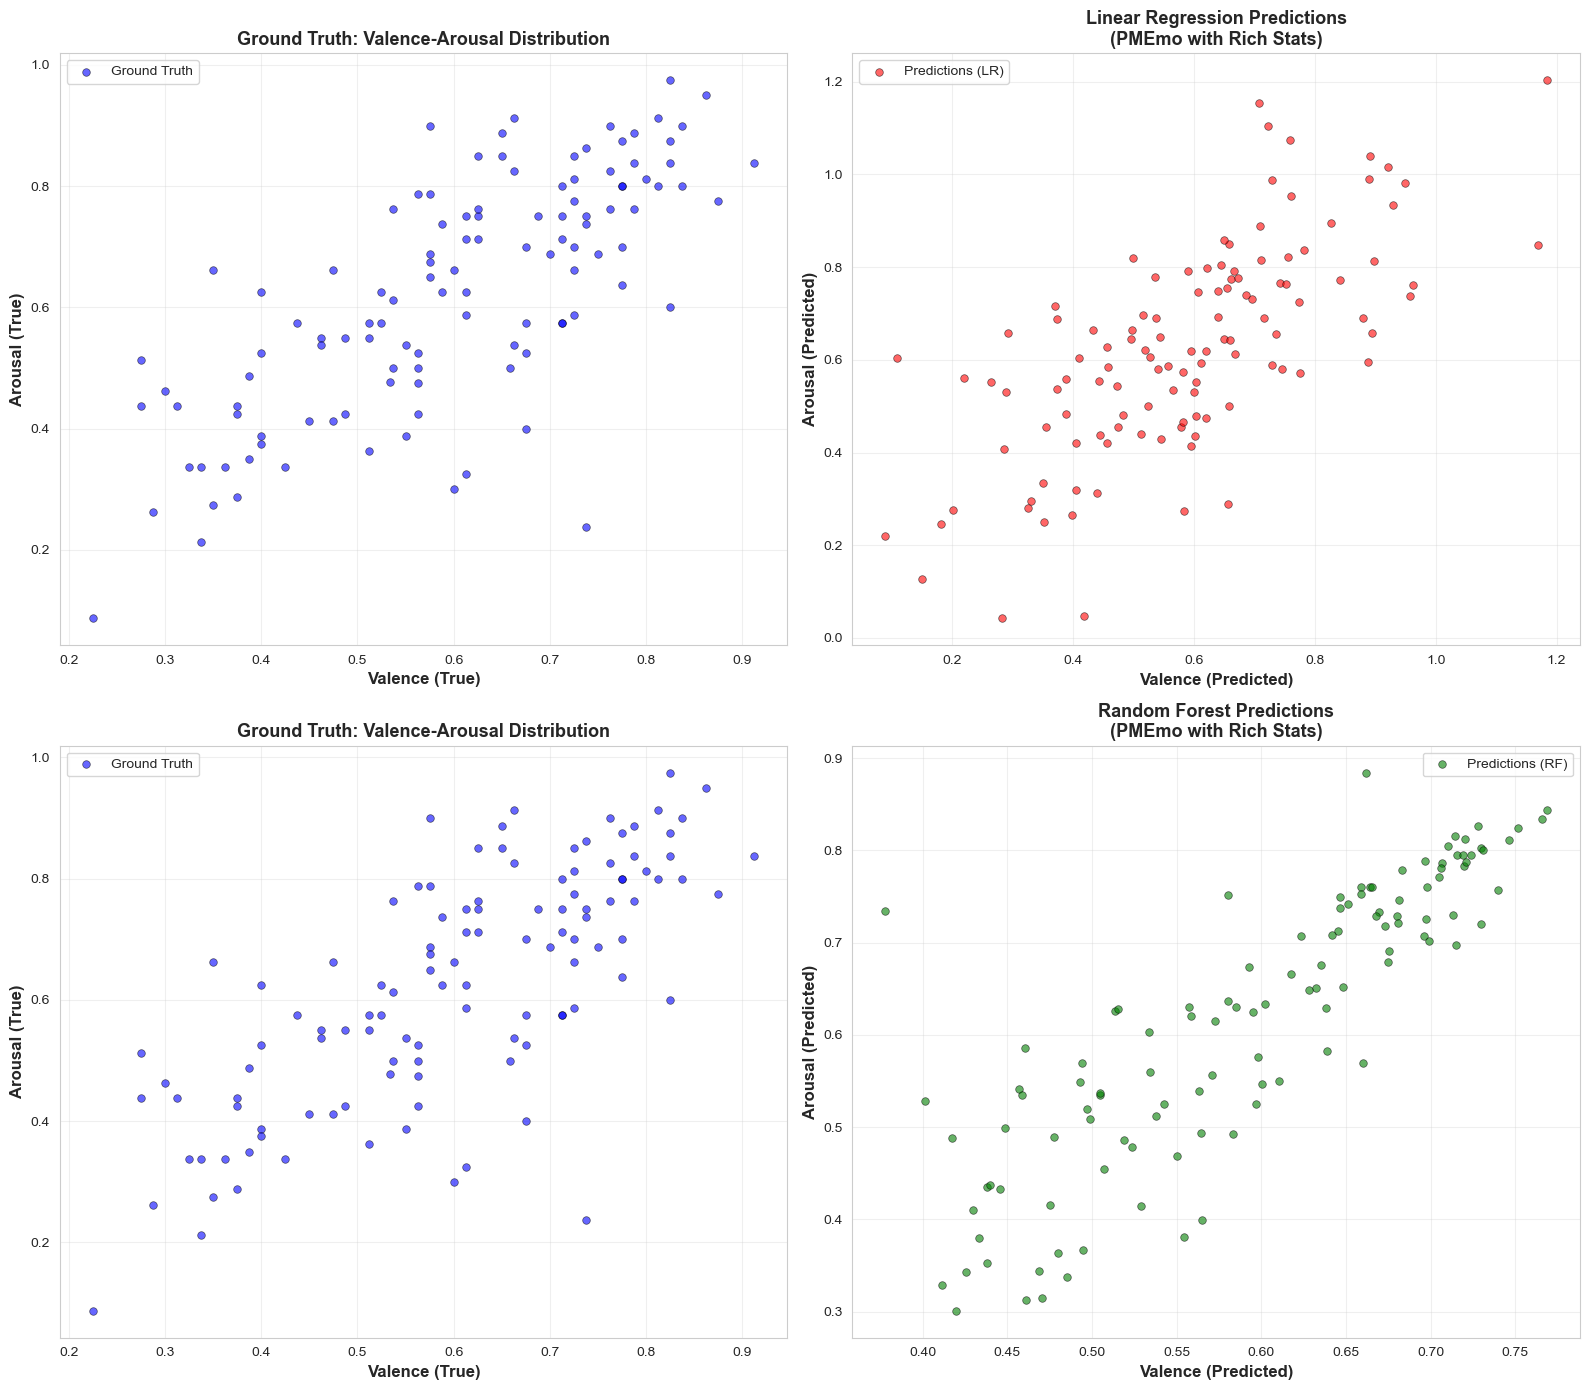

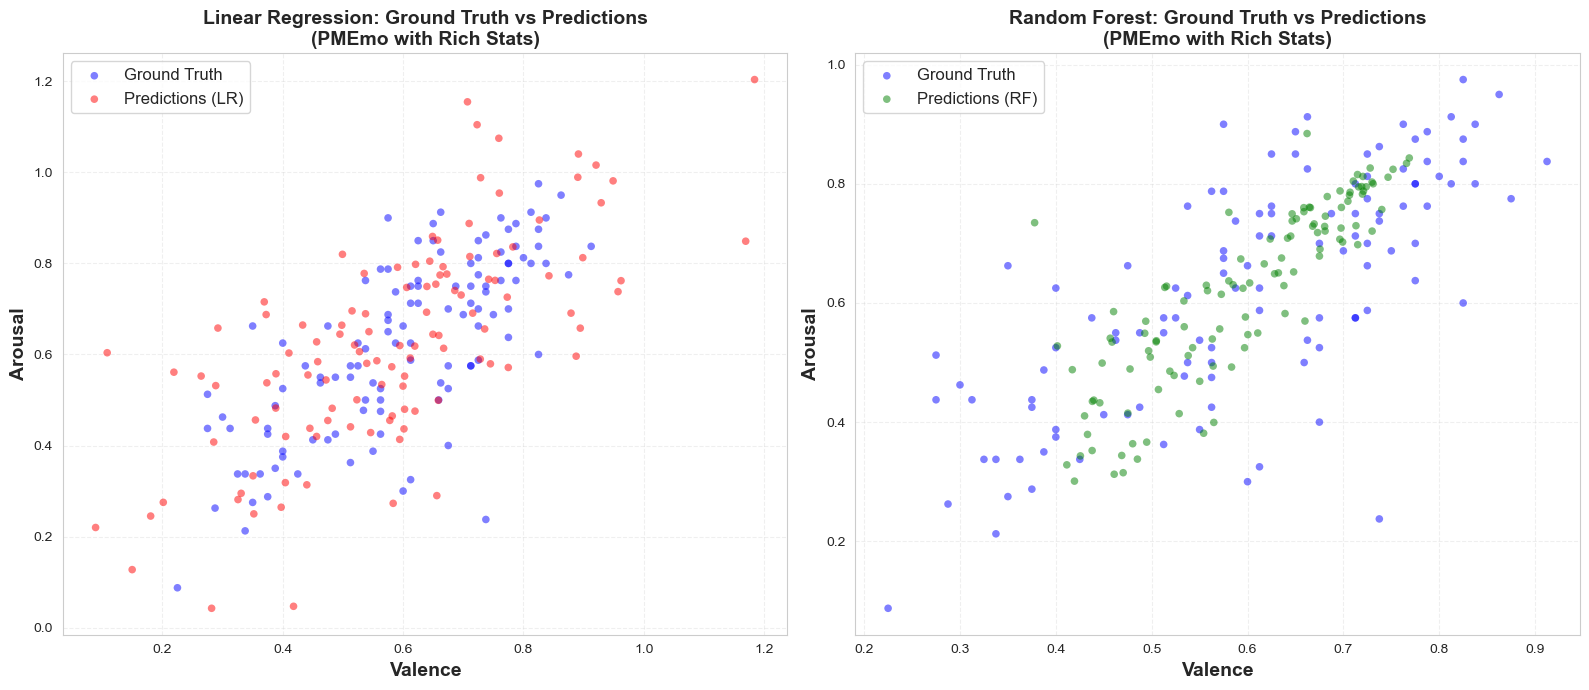

In [14]:
# Create figures directory
FIGURE_DIR = BASE_DIR / 'docs' / 'figures'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

# 2D Space comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Linear Regression - Ground Truth
axes[0, 0].scatter(y_val_val, y_aro_val, alpha=0.6, s=30, c='blue', 
                   edgecolors='black', linewidths=0.5, label='Ground Truth')
axes[0, 0].set_xlabel('Valence (True)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Arousal (True)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Ground Truth: Valence-Arousal Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Linear Regression - Predictions
axes[0, 1].scatter(lr_val_val_pred, lr_aro_val_pred, alpha=0.6, s=30, c='red', 
                   edgecolors='black', linewidths=0.5, label='Predictions (LR)')
axes[0, 1].set_xlabel('Valence (Predicted)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Arousal (Predicted)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Linear Regression Predictions\n(PMEmo with Rich Stats)', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Random Forest - Ground Truth
axes[1, 0].scatter(y_val_val, y_aro_val, alpha=0.6, s=30, c='blue', 
                   edgecolors='black', linewidths=0.5, label='Ground Truth')
axes[1, 0].set_xlabel('Valence (True)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Arousal (True)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Ground Truth: Valence-Arousal Distribution', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Random Forest - Predictions
axes[1, 1].scatter(rf_val_val_pred, rf_aro_val_pred, alpha=0.6, s=30, c='green', 
                   edgecolors='black', linewidths=0.5, label='Predictions (RF)')
axes[1, 1].set_xlabel('Valence (Predicted)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Arousal (Predicted)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Random Forest Predictions\n(PMEmo with Rich Stats)', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'pmemo_valence_arousal_2d_space.png', dpi=150, bbox_inches='tight')
plt.show()

# Overlay comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Linear Regression - Ground Truth vs Predictions (overlay)
axes[0].scatter(y_val_val, y_aro_val, alpha=0.5, s=30, c='blue', 
                edgecolors='none', label='Ground Truth')
axes[0].scatter(lr_val_val_pred, lr_aro_val_pred, alpha=0.5, s=30, c='red', 
                edgecolors='none', label='Predictions (LR)')
axes[0].set_xlabel('Valence', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Arousal', fontsize=14, fontweight='bold')
axes[0].set_title('Linear Regression: Ground Truth vs Predictions\n(PMEmo with Rich Stats)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='upper left')
axes[0].grid(alpha=0.3, linestyle='--')

# Right: Random Forest - Ground Truth vs Predictions (overlay)
axes[1].scatter(y_val_val, y_aro_val, alpha=0.5, s=30, c='blue', 
                edgecolors='none', label='Ground Truth')
axes[1].scatter(rf_val_val_pred, rf_aro_val_pred, alpha=0.5, s=30, c='green', 
                edgecolors='none', label='Predictions (RF)')
axes[1].set_xlabel('Valence', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Arousal', fontsize=14, fontweight='bold')
axes[1].set_title('Random Forest: Ground Truth vs Predictions\n(PMEmo with Rich Stats)', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='upper left')
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'pmemo_valence_arousal_2d_overlay.png', dpi=150, bbox_inches='tight')
plt.show()


## 10. Comparison with DEAM


In [15]:
# Compare with DEAM results
deam_results = {
    'Dataset': 'DEAM',
    'Songs': 1802,
    'Features': '133 dim (mean/std)',
    'LR Val R²': 0.458,
    'LR Aro R²': 0.498,
    'RF Val R²': 0.489,
    'RF Aro R²': 0.531
}

pmemo_results = {
    'Dataset': 'PMEmo',
    'Songs': len(df_final),
    'Features': f'{X.shape[1]} dim (Rich Stats ✨)',
    'LR Val R²': lr_val_results[1]['R²'],
    'LR Aro R²': lr_aro_results[1]['R²'],
    'RF Val R²': rf_val_results[1]['R²'],
    'RF Aro R²': rf_aro_results[1]['R²']
}

comparison_table = pd.DataFrame([deam_results, pmemo_results])
print("📊 PMEmo (Rich Stats) vs DEAM (mean/std) Performance Comparison")
print(comparison_table.to_string(index=False))


📊 PMEmo (Rich Stats) vs DEAM (mean/std) Performance Comparison
Dataset  Songs               Features  LR Val R²  LR Aro R²  RF Val R²  RF Aro R²
   DEAM   1802     133 dim (mean/std)   0.458000    0.49800   0.489000   0.531000
  PMEmo    767 334 dim (Rich Stats ✨)  -0.370281    0.29423   0.475328   0.677463


## 11. SVR Models (Paper Method)

According to the PMEmo paper, they used multiple regressors, with **SVR performing best**.

**Paper results** (6373-dim ComParE features):
- Valence: RMSE = 0.124, r = 0.638
- Arousal: RMSE = 0.102, r = 0.764

**Our features**: 334-dim Rich Stats


In [16]:
# SVR with RBF kernel
svr_val = SVR(kernel='rbf', gamma='scale', C=1.0)
svr_aro = SVR(kernel='rbf', gamma='scale', C=1.0)

svr_val.fit(X_train_scaled, y_val_train)
svr_aro.fit(X_train_scaled, y_aro_train)

# Predictions
svr_val_train_pred = svr_val.predict(X_train_scaled)
svr_val_val_pred = svr_val.predict(X_val_scaled)

svr_aro_train_pred = svr_aro.predict(X_train_scaled)
svr_aro_val_pred = svr_aro.predict(X_val_scaled)

# Evaluate - Valence
svr_val_train_results = evaluate_model(y_val_train, svr_val_train_pred, 
                                        dataset_name="Train", target_range=VALENCE_RANGE)
print_evaluation(svr_val_train_results, "SVR - Valence Performance")

svr_val_val_results = evaluate_model(y_val_val, svr_val_val_pred, 
                                      dataset_name="Validation", target_range=VALENCE_RANGE)
print_evaluation(svr_val_val_results)

# Pearson correlation coefficient
val_r_train, _ = pearsonr(y_val_train, svr_val_train_pred)
val_r_val, _ = pearsonr(y_val_val, svr_val_val_pred)
print(f"\nPearson r (Train): {val_r_train:.4f}")
print(f"Pearson r (Val):   {val_r_val:.4f}")

# Evaluate - Arousal
svr_aro_train_results = evaluate_model(y_aro_train, svr_aro_train_pred, 
                                        dataset_name="Train", target_range=AROUSAL_RANGE)
print_evaluation(svr_aro_train_results, "\nSVR - Arousal Performance")

svr_aro_val_results = evaluate_model(y_aro_val, svr_aro_val_pred, 
                                      dataset_name="Validation", target_range=AROUSAL_RANGE)
print_evaluation(svr_aro_val_results)

aro_r_train, _ = pearsonr(y_aro_train, svr_aro_train_pred)
aro_r_val, _ = pearsonr(y_aro_val, svr_aro_val_pred)
print(f"\nPearson r (Train): {aro_r_train:.4f}")
print(f"Pearson r (Val):   {aro_r_val:.4f}")



SVR - Valence Performance
------------------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
------------------------------------------------------------------------------------------
Train               0.0061     0.0779     0.0704     0.7747     0.0989
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Dataset                MSE       RMSE        MAE         R²      NRMSE
------------------------------------------------------------------------------------------
Validation          0.0137     0.1169     0.0910     0.4768     0.1484
------------------------------------------------------------------------------------------

Pearson r (Train): 0.9005
Pearson r (Val):   0.6965


SVR - Arousal Performance
--------------------------------------------------------------

## 12. SVR Valence-Arousal 2D Space Visualization


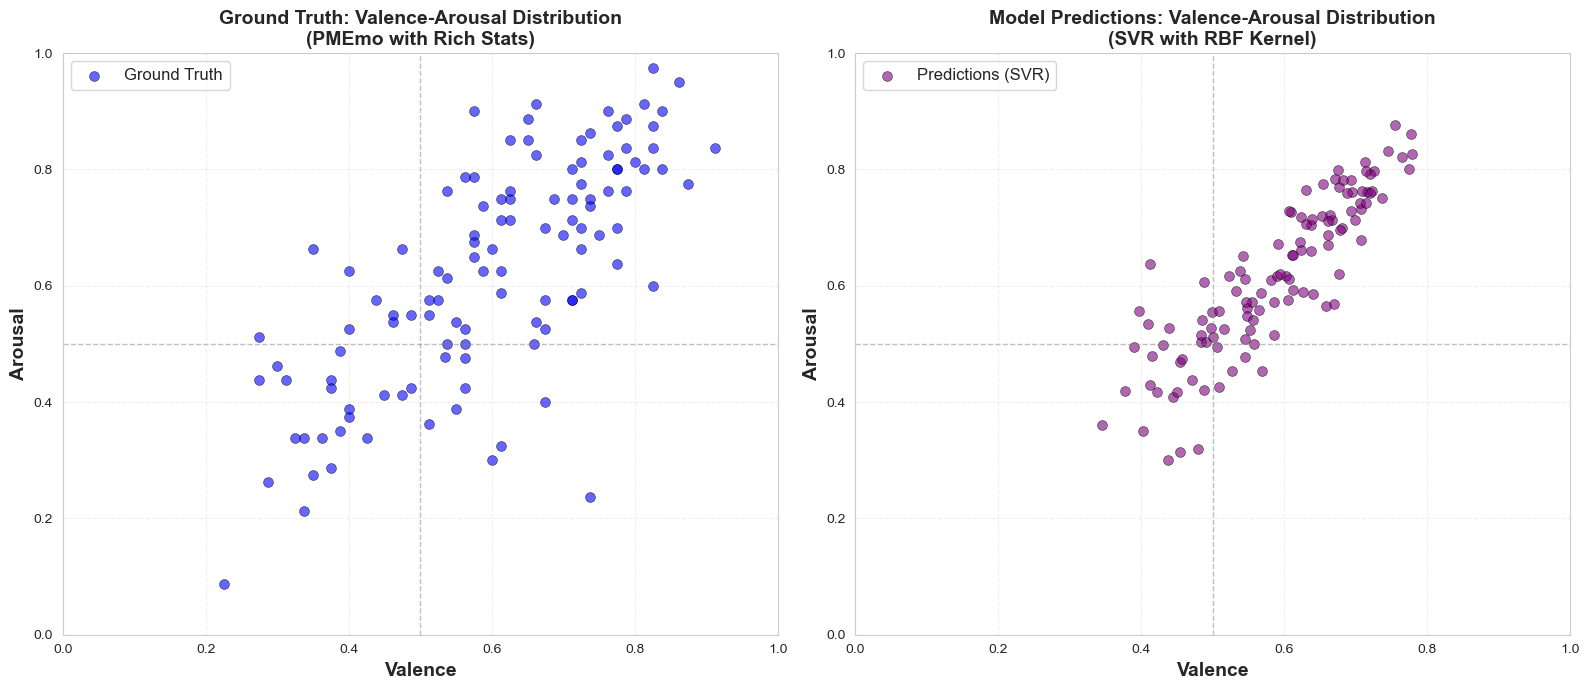

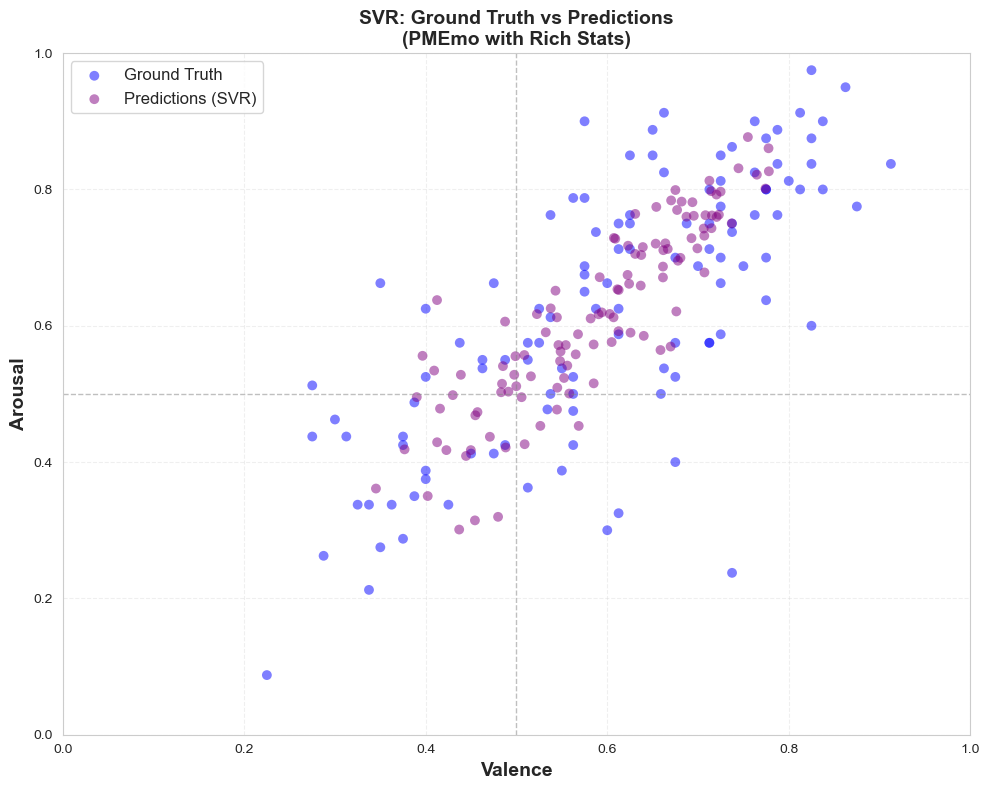

In [17]:
# SVR 2D Space Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Ground Truth
axes[0].scatter(y_val_val, y_aro_val, alpha=0.6, s=50, c='blue', 
                edgecolors='black', linewidth=0.5, label='Ground Truth')
axes[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Valence', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Arousal', fontsize=14, fontweight='bold')
axes[0].set_title('Ground Truth: Valence-Arousal Distribution\n(PMEmo with Rich Stats)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=12, loc='upper left')
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# Right: SVR Predictions
axes[1].scatter(svr_val_val_pred, svr_aro_val_pred, alpha=0.6, s=50, c='purple', 
                edgecolors='black', linewidth=0.5, label='Predictions (SVR)')
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Valence', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Arousal', fontsize=14, fontweight='bold')
axes[1].set_title('Model Predictions: Valence-Arousal Distribution\n(SVR with RBF Kernel)', 
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=12, loc='upper left')
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'pmemo_valence_arousal_2d_space_svr.png', dpi=150, bbox_inches='tight')
plt.show()

# Overlay plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(y_val_val, y_aro_val, alpha=0.5, s=50, c='blue', 
           edgecolors='none', label='Ground Truth')
ax.scatter(svr_val_val_pred, svr_aro_val_pred, alpha=0.5, s=50, c='purple', 
           edgecolors='none', label='Predictions (SVR)')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Valence', fontsize=14, fontweight='bold')
ax.set_ylabel('Arousal', fontsize=14, fontweight='bold')
ax.set_title('SVR: Ground Truth vs Predictions\n(PMEmo with Rich Stats)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'pmemo_valence_arousal_2d_overlay_svr.png', dpi=150, bbox_inches='tight')
plt.show()


## 13. Three-Model Comparison: LR vs RF vs SVR (Shortcut Detection)


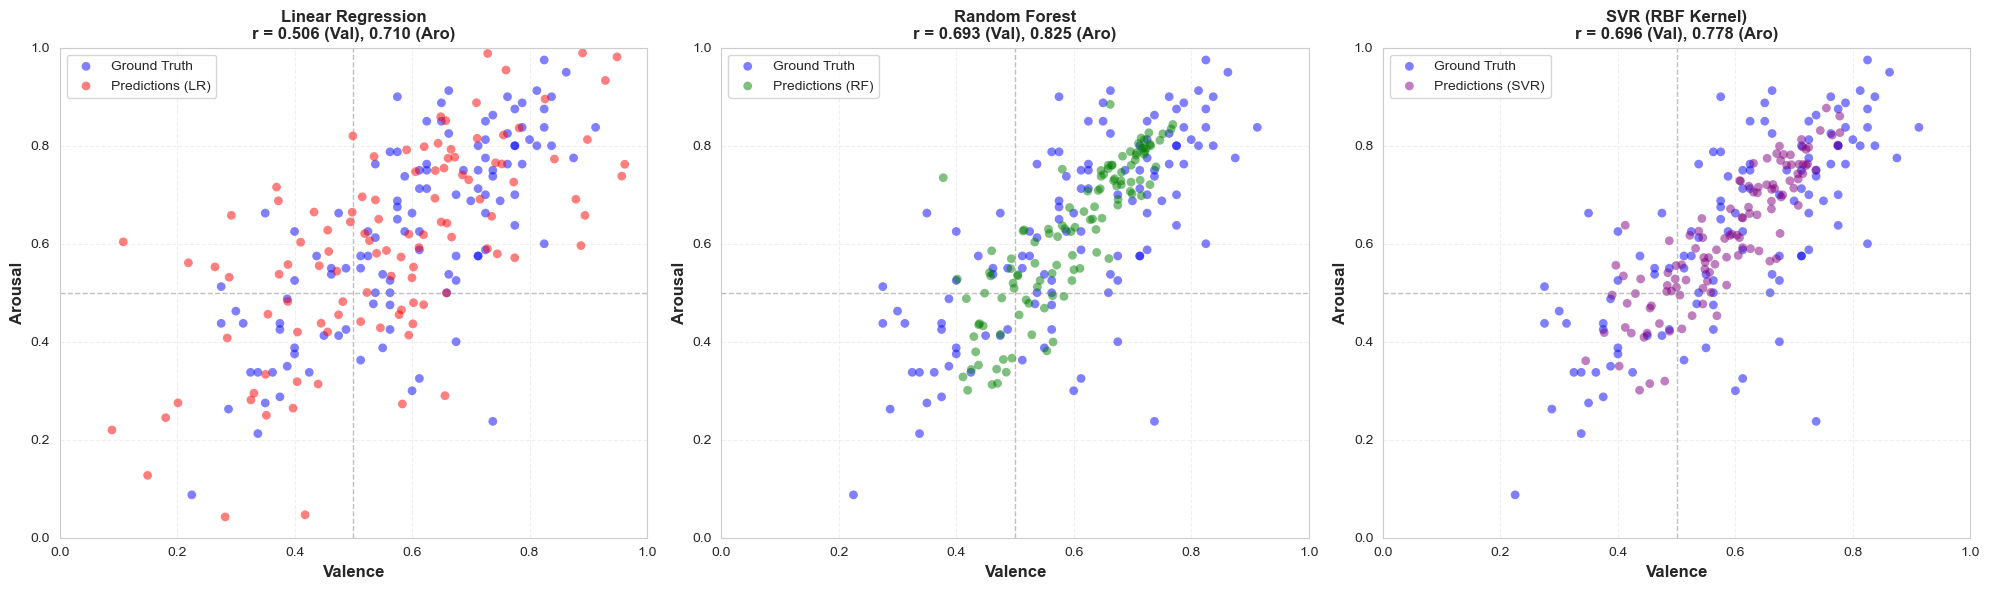


📊 Prediction Range Statistics (Shortcut Detection)

Model                   Val Range    Val Std    Aro Range    Aro Std
------------------------------------------------------------------------------------------
Ground Truth               0.6875     0.1616       0.8875     0.1932
Linear Regression          1.0950     0.2087       1.1614     0.2256
Random Forest              0.3909     0.1029       0.5834     0.1503
SVR (RBF)                  0.4329     0.1056       0.5758     0.1329


In [18]:
# Calculate Pearson correlation coefficients - use independent variable names
lr_val_r, _ = pearsonr(y_val_val, lr_val_val_pred)
lr_aro_r, _ = pearsonr(y_aro_val, lr_aro_val_pred)

rf_val_r, _ = pearsonr(y_val_val, rf_val_val_pred)
rf_aro_r, _ = pearsonr(y_aro_val, rf_aro_val_pred)

svr_val_r, _ = pearsonr(y_val_val, svr_val_val_pred)
svr_aro_r, _ = pearsonr(y_aro_val, svr_aro_val_pred)

# Three-model comparison plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Subplot 1: Linear Regression
axes[0].scatter(y_val_val, y_aro_val, alpha=0.5, s=40, c='blue', 
                edgecolors='none', label='Ground Truth')
axes[0].scatter(lr_val_val_pred, lr_aro_val_pred, alpha=0.5, s=40, c='red', 
                edgecolors='none', label='Predictions (LR)')
axes[0].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('Valence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Arousal', fontsize=12, fontweight='bold')
axes[0].set_title(f'Linear Regression\nr = {lr_val_r:.3f} (Val), {lr_aro_r:.3f} (Aro)', 
                  fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# Subplot 2: Random Forest
axes[1].scatter(y_val_val, y_aro_val, alpha=0.5, s=40, c='blue', 
                edgecolors='none', label='Ground Truth')
axes[1].scatter(rf_val_val_pred, rf_aro_val_pred, alpha=0.5, s=40, c='green', 
                edgecolors='none', label='Predictions (RF)')
axes[1].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Valence', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Arousal', fontsize=12, fontweight='bold')
axes[1].set_title(f'Random Forest\nr = {rf_val_r:.3f} (Val), {rf_aro_r:.3f} (Aro)', 
                  fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

# Subplot 3: SVR
axes[2].scatter(y_val_val, y_aro_val, alpha=0.5, s=40, c='blue', 
                edgecolors='none', label='Ground Truth')
axes[2].scatter(svr_val_val_pred, svr_aro_val_pred, alpha=0.5, s=40, c='purple', 
                edgecolors='none', label='Predictions (SVR)')
axes[2].axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[2].axvline(x=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_xlabel('Valence', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Arousal', fontsize=12, fontweight='bold')
axes[2].set_title(f'SVR (RBF Kernel)\nr = {svr_val_r:.3f} (Val), {svr_aro_r:.3f} (Aro)', 
                  fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10, loc='upper left')
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIGURE_DIR / 'pmemo_three_models_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Prediction range statistics
def calculate_range_coverage(pred_val, pred_aro):
    """Calculate prediction range coverage"""
    return {
        'Valence_min': pred_val.min(),
        'Valence_max': pred_val.max(),
        'Valence_range': pred_val.max() - pred_val.min(),
        'Valence_std': pred_val.std(),
        'Arousal_min': pred_aro.min(),
        'Arousal_max': pred_aro.max(),
        'Arousal_range': pred_aro.max() - pred_aro.min(),
        'Arousal_std': pred_aro.std()
    }

gt_coverage = calculate_range_coverage(y_val_val, y_aro_val)
lr_coverage = calculate_range_coverage(lr_val_val_pred, lr_aro_val_pred)
rf_coverage = calculate_range_coverage(rf_val_val_pred, rf_aro_val_pred)
svr_coverage = calculate_range_coverage(svr_val_val_pred, svr_aro_val_pred)

print("\n📊 Prediction Range Statistics (Shortcut Detection)")
print(f"\n{'Model':<20} {'Val Range':>12} {'Val Std':>10} {'Aro Range':>12} {'Aro Std':>10}")
print("-" * 90)
print(f"{'Ground Truth':<20} {gt_coverage['Valence_range']:>12.4f} {gt_coverage['Valence_std']:>10.4f} "
      f"{gt_coverage['Arousal_range']:>12.4f} {gt_coverage['Arousal_std']:>10.4f}")
print(f"{'Linear Regression':<20} {lr_coverage['Valence_range']:>12.4f} {lr_coverage['Valence_std']:>10.4f} "
      f"{lr_coverage['Arousal_range']:>12.4f} {lr_coverage['Arousal_std']:>10.4f}")
print(f"{'Random Forest':<20} {rf_coverage['Valence_range']:>12.4f} {rf_coverage['Valence_std']:>10.4f} "
      f"{rf_coverage['Arousal_range']:>12.4f} {rf_coverage['Arousal_std']:>10.4f}")
print(f"{'SVR (RBF)':<20} {svr_coverage['Valence_range']:>12.4f} {svr_coverage['Valence_std']:>10.4f} "
      f"{svr_coverage['Arousal_range']:>12.4f} {svr_coverage['Arousal_std']:>10.4f}")


## 14. 10-Fold Cross-Validation (Paper Method)

PMEmo paper uses **11-fold cross-validation** for model evaluation.

**Paper evaluation method**:
- No fixed train/test split
- Use k-fold cross-validation
- Evaluation metrics: RMSE + Pearson r


In [19]:
# Merge train and validation sets
X_all = np.vstack([X_train_scaled, X_val_scaled])
y_val_all = np.concatenate([y_val_train, y_val_val])
y_aro_all = np.concatenate([y_aro_train, y_aro_val])

print(f"Total samples for CV: {len(X_all)}")
print(f"Each fold: ~{len(X_all)//10} samples")

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate_with_cv(model, X, y, cv=10, model_name="Model"):
    """Evaluate model using cross-validation"""
    import time
    
    start_time = time.time()
    
    # RMSE
    rmse_scores = -cross_val_score(model, X, y, cv=cv, 
                                     scoring='neg_root_mean_squared_error')
    
    # Get predictions for Pearson r
    y_pred = cross_val_predict(model, X, y, cv=cv)
    r, _ = pearsonr(y, y_pred)
    
    elapsed_time = time.time() - start_time
    print(f"{model_name} completed in {elapsed_time:.1f}s")
    
    return {
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'Pearson_r': r,
        'time': elapsed_time
    }

# Evaluate models
lr_val_cv = evaluate_with_cv(LinearRegression(), X_all, y_val_all, cv=10, 
                              model_name="Linear Regression (Valence)")
lr_aro_cv = evaluate_with_cv(LinearRegression(), X_all, y_aro_all, cv=10, 
                              model_name="Linear Regression (Arousal)")

rf_val_cv = evaluate_with_cv(RandomForestRegressor(n_estimators=50, max_depth=10, 
                                                    random_state=RANDOM_STATE, n_jobs=-1), 
                              X_all, y_val_all, cv=10,
                              model_name="Random Forest (Valence)")
rf_aro_cv = evaluate_with_cv(RandomForestRegressor(n_estimators=50, max_depth=10,
                                                    random_state=RANDOM_STATE, n_jobs=-1), 
                              X_all, y_aro_all, cv=10,
                              model_name="Random Forest (Arousal)")

svr_val_cv = evaluate_with_cv(SVR(kernel='rbf', gamma='scale'), 
                               X_all, y_val_all, cv=10,
                               model_name="SVR RBF (Valence)")
svr_aro_cv = evaluate_with_cv(SVR(kernel='rbf', gamma='scale'), 
                               X_all, y_aro_all, cv=10,
                               model_name="SVR RBF (Arousal)")

# Print results
print("\n📊 10-Fold Cross-Validation Results")
print(f"\n{'Model':<25} {'Target':<10} {'RMSE (mean±std)':>25} {'Pearson r':>12}")
print("-" * 90)

print(f"{'Linear Regression':<25} {'Valence':<10} "
      f"{lr_val_cv['RMSE_mean']:>10.4f}±{lr_val_cv['RMSE_std']:<8.4f} "
      f"{lr_val_cv['Pearson_r']:>12.4f}")
print(f"{'Linear Regression':<25} {'Arousal':<10} "
      f"{lr_aro_cv['RMSE_mean']:>10.4f}±{lr_aro_cv['RMSE_std']:<8.4f} "
      f"{lr_aro_cv['Pearson_r']:>12.4f}")

print(f"{'Random Forest':<25} {'Valence':<10} "
      f"{rf_val_cv['RMSE_mean']:>10.4f}±{rf_val_cv['RMSE_std']:<8.4f} "
      f"{rf_val_cv['Pearson_r']:>12.4f}")
print(f"{'Random Forest':<25} {'Arousal':<10} "
      f"{rf_aro_cv['RMSE_mean']:>10.4f}±{rf_aro_cv['RMSE_std']:<8.4f} "
      f"{rf_aro_cv['Pearson_r']:>12.4f}")

print(f"{'SVR (RBF)':<25} {'Valence':<10} "
      f"{svr_val_cv['RMSE_mean']:>10.4f}±{svr_val_cv['RMSE_std']:<8.4f} "
      f"{svr_val_cv['Pearson_r']:>12.4f}")
print(f"{'SVR (RBF)':<25} {'Arousal':<10} "
      f"{svr_aro_cv['RMSE_mean']:>10.4f}±{svr_aro_cv['RMSE_std']:<8.4f} "
      f"{svr_aro_cv['Pearson_r']:>12.4f}")

total_time = (lr_val_cv['time'] + lr_aro_cv['time'] + 
              rf_val_cv['time'] + rf_aro_cv['time'] + 
              svr_val_cv['time'] + svr_aro_cv['time'])
print(f"\nTotal CV time: {total_time:.1f}s ({total_time/60:.1f} minutes)")


Total samples for CV: 651
Each fold: ~65 samples
Linear Regression (Valence) completed in 0.9s
Linear Regression (Arousal) completed in 0.8s
Random Forest (Valence) completed in 13.0s
Random Forest (Arousal) completed in 12.4s
SVR RBF (Valence) completed in 0.4s
SVR RBF (Arousal) completed in 0.4s

📊 10-Fold Cross-Validation Results

Model                     Target               RMSE (mean±std)    Pearson r
------------------------------------------------------------------------------------------
Linear Regression         Valence        0.2717±0.2927         0.3238
Linear Regression         Arousal        0.1887±0.1079         0.5736
Random Forest             Valence        0.1166±0.0128         0.6983
Random Forest             Arousal        0.1073±0.0051         0.8142
SVR (RBF)                 Valence        0.1185±0.0116         0.6892
SVR (RBF)                 Arousal        0.1158±0.0058         0.7875

Total CV time: 27.9s (0.5 minutes)


## 15. Evaluation Method Comparison


In [20]:
# Compare with PMEmo paper
print("📊 Comparison with PMEmo Paper Results")
print(f"\n{'Method':<30} {'Features':<25} {'Val RMSE':>12} {'Aro RMSE':>12} {'Val r':>10} {'Aro r':>10}")
print("-" * 90)
print(f"{'PMEmo Paper (SVR)':<30} {'6373-dim ComParE':<25} "
      f"{'0.124':>12} {'0.102':>12} {'0.638':>10} {'0.764':>10}")
print(f"{'Our Method (SVR + 10-fold)':<30} {'334-dim Rich Stats':<25} "
      f"{svr_val_cv['RMSE_mean']:>12.4f} {svr_aro_cv['RMSE_mean']:>12.4f} "
      f"{svr_val_cv['Pearson_r']:>10.4f} {svr_aro_cv['Pearson_r']:>10.4f}")


📊 Comparison with PMEmo Paper Results

Method                         Features                      Val RMSE     Aro RMSE      Val r      Aro r
------------------------------------------------------------------------------------------
PMEmo Paper (SVR)              6373-dim ComParE                 0.124        0.102      0.638      0.764
Our Method (SVR + 10-fold)     334-dim Rich Stats              0.1185       0.1158     0.6892     0.7875
